In [11]:
import numpy as np
# 给定一个距离矩阵 和 一组的距离, 返回该距离在距离矩阵中的排名
def get_ranks_of_distance(distances, distance_matrix):
    # distance[i] 在 distance_matrix[i]中排第几
    ranks = []
    for i in range(distance_matrix.shape[0]):
        ranks.append(np.sum(distance_matrix[i] < distances[i])+1)
    return ranks
# 给定ranks向量, 和一个阈值, 返回向量中<=阈值的个数
def count_less_than_or_equal_to_threshold(ranks, threshold):
    return sum([1 for rank in ranks if rank <= threshold])



# 创建一个示例距离矩阵
distance_matrix = np.array([
    [0.0, 0.3, 0.2, 0.4],
    [0.3, 0.0, 0.5, 0.1],
    [0.2, 0.5, 0.0, 0.6],
    [0.4, 0.1, 0.6, 0.0]
])

# 给定一组距离, 返回该距离在距离矩阵中的排名
distances = [0.7, 0.5, 0.6, 0.1]
ranks = get_ranks_of_distance(distances, distance_matrix)

print(ranks) # [2, 3, 4, 2]

num_malicious = 0
# 给定ranks向量, 和一个阈值, 返回向量中<=阈值的个数
rank_threshold = distance_matrix.shape[0]//2 - num_malicious
count = count_less_than_or_equal_to_threshold(ranks, rank_threshold)


[5, 4, 4, 2]


In [4]:
# 距离矩阵转为投票向量
def votes_by_dismatrix(dis_matrix):
    # 获取每行前half_clients个最小距离值的索引
    half_ = dis_matrix.shape[0] // 2
    top_indices = np.argsort(dis_matrix, axis=1)[:, :half_]
    # 创建一个全零的矩阵，然后将每行的[half_clients个最小距离值的索引]位置标为1
    result_matrix = np.zeros_like(dis_matrix)
    rows, cols = np.indices(top_indices.shape)
    result_matrix[rows, top_indices] = 1
    print(result_matrix)
    column_sums = np.sum(result_matrix, axis=0)
    return column_sums

votes = votes_by_dismatrix(distance_matrix)
votes



[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]]


array([2., 2., 2., 2.])

In [12]:
import torch
import torch.nn as nn
import numpy as np

# 定义测试用的简单神经网络
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义函数
def update_update_convert_to_vector(model_update):
    return torch.cat([model_update[k].flatten() for k in model_update])

def extract_shapes(state_dict):
    shape_dict = {}
    for name, param in state_dict.items():
        shape_dict[name] = param.shape
    return shape_dict

def vector_to_state_dict(vector, shape_dict, benign_update_length):
    assert benign_update_length == len(vector)
    state_dict = {}
    start = 0
    for name, shape in shape_dict.items():
        length = np.prod(shape)
        state_dict[name] = vector[start:start+length].view(shape)
        start += length
    return state_dict

# 测试函数
def run_tests():
    # 创建模型和模型更新
    model = SimpleNet()
    original_state_dict = model.state_dict()
    model_update = {name: param.clone() for name, param in original_state_dict.items()}
    
    # 测试 update_update_convert_to_vector
    update_vector = update_update_convert_to_vector(model_update)
    print(f"1. update_update_convert_to_vector test:")
    print(f"   Vector shape: {update_vector.shape}")
    print(f"   Vector sum: {update_vector.sum()}")
    
    # 测试 extract_shapes
    shape_dict = extract_shapes(model_update)
    print(f"\n2. extract_shapes test:")
    for name, shape in shape_dict.items():
        print(f"   {name}: {shape}")
    
    # 计算总参数数量
    benign_update_length = sum([np.prod(shape) for shape in shape_dict.values()])
    print(f"\n   Total parameters: {benign_update_length}")
    
    # 测试 vector_to_state_dict
    reconstructed_state_dict = vector_to_state_dict(update_vector, shape_dict, benign_update_length)
    print(f"\n3. vector_to_state_dict test:")
    for name in reconstructed_state_dict:
        original = model_update[name]
        reconstructed = reconstructed_state_dict[name]
        is_equal = torch.all(torch.eq(original, reconstructed))
        print(f"   {name}: {'Match' if is_equal else 'Mismatch'}")
    
    # 验证整个过程的正确性
    is_valid = all(torch.all(torch.eq(model_update[name], reconstructed_state_dict[name])) for name in model_update)
    print(f"\nOverall process validation: {'Successful' if is_valid else 'Failed'}")

# 运行测试
run_tests()

1. update_update_convert_to_vector test:
   Vector shape: torch.Size([67])
   Vector sum: 1.730630874633789

2. extract_shapes test:
   fc1.weight: torch.Size([5, 10])
   fc1.bias: torch.Size([5])
   fc2.weight: torch.Size([2, 5])
   fc2.bias: torch.Size([2])

   Total parameters: 67

3. vector_to_state_dict test:
   fc1.weight: Match
   fc1.bias: Match
   fc2.weight: Match
   fc2.bias: Match

Overall process validation: Successful


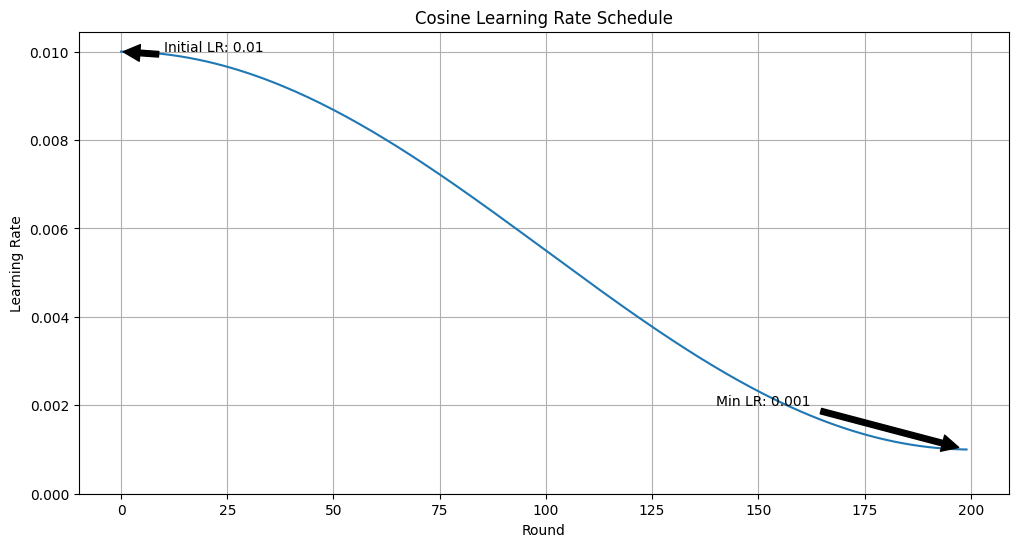

In [13]:
import math
import matplotlib.pyplot as plt

def cosine_learning_rate(current_round, total_rounds, initial_lr=0.001, min_lr=0):
    return min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(math.pi * current_round / total_rounds))

# 设置参数
total_rounds = 200
initial_lr = 0.01
min_lr = 0.001

# 计算每个回合的学习率
lr_schedule = [cosine_learning_rate(r, total_rounds, initial_lr, min_lr) for r in range(total_rounds)]

# 创建图表
plt.figure(figsize=(12, 6))
plt.plot(range(total_rounds), lr_schedule)
plt.title('Cosine Learning Rate Schedule')
plt.xlabel('Round')
plt.ylabel('Learning Rate')
plt.grid(True)

# 设置y轴的范围，使其从0开始
plt.ylim(bottom=0)

# 添加一些关键点的标注
plt.annotate(f'Initial LR: {initial_lr}', xy=(0, initial_lr), xytext=(10, initial_lr),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min LR: {min_lr}', xy=(total_rounds-1, min_lr), xytext=(total_rounds-60, min_lr*2),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

In [1]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(dim * mlp_ratio, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class MobileViTBlock(nn.Module):
    def __init__(self, in_channels, dim, patch_size, num_transformer_blocks):
        super().__init__()
        self.patch_size = patch_size
        self.local_rep = nn.Sequential(
            ConvBlock(in_channels, in_channels),
            ConvBlock(in_channels, dim)
        )
        self.transformer = nn.Sequential(*[TransformerBlock(dim, num_heads=4) for _ in range(num_transformer_blocks)])
        self.fusion = ConvBlock(dim, in_channels)

    def forward(self, x):
        y = self.local_rep(x)
        B, C, H, W = y.shape
        y = y.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        y = y.permute(0, 2, 4, 1, 3, 5).reshape(B * (H // self.patch_size) * (W // self.patch_size), C, -1)
        y = self.transformer(y.transpose(1, 2)).transpose(1, 2)
        y = y.reshape(B, H // self.patch_size, W // self.patch_size, C, self.patch_size, self.patch_size)
        y = y.permute(0, 3, 1, 4, 2, 5).reshape(B, C, H, W)
        y = self.fusion(y)
        return x + y

class MobileViT(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, dims=[96, 120, 144], patch_sizes=[2, 2, 2], num_transformer_blocks=[2, 4, 3]):
        super().__init__()
        self.stem = ConvBlock(in_channels, 16, stride=2)
        
        self.stages = nn.ModuleList([
            self._make_stage(16, 32, dims[0], patch_sizes[0], num_transformer_blocks[0]),
            self._make_stage(32, 64, dims[1], patch_sizes[1], num_transformer_blocks[1]),
            self._make_stage(64, 96, dims[2], patch_sizes[2], num_transformer_blocks[2])
        ])
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(96, num_classes)

    def _make_stage(self, in_channels, out_channels, dim, patch_size, num_transformer_blocks):
        return nn.Sequential(
            ConvBlock(in_channels, out_channels, stride=2),
            MobileViTBlock(out_channels, dim, patch_size, num_transformer_blocks)
        )

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

# 创建一个 MobileViT 模型示例
model = MobileViT(num_classes=10)  # 适用于 Imagenette 的 10 个类别

In [2]:
# 打印模型结构
print(model)

MobileViT(
  (stem): ConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU()
      )
      (1): MobileViTBlock(
        (local_rep): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): SiLU()
          )
          (1): ConvBlock(
            (conv): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(96, eps=

In [3]:
# 打印参数总量
num_params = sum(p.numel() for p in model.parameters())
print(f"\nNumber of parameters: {num_params}")


Number of parameters: 2326266


In [5]:
# 对于每一层，打印输出形状, 以及参数数量, 以及dtype
for name, param in model.named_parameters():
    # print(f"{name}: {param.shape} - {param.numel()} parameters - {param.dtype}")
    # if name不包含weight或bias，那么这是一个非模型参数，打印
    if 'weight' not in name and 'bias' not in name:
        print(param)


In [7]:
import torch
import torch.nn as nn

class ConvBNAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion_factor=4):
        super().__init__()
        hidden_dim = in_channels * expansion_factor
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expansion_factor != 1:
            layers.append(ConvBNAct(in_channels, hidden_dim, kernel_size=1))
        layers.extend([
            ConvBNAct(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = ConvBNAct(channel, channel, kernel_size)
        self.conv2 = ConvBNAct(channel, dim, kernel_size=1)

        self.transformer = nn.Sequential(*[
            nn.Sequential(
                nn.LayerNorm(dim),
                nn.MultiheadAttention(dim, 4, batch_first=True),
                nn.LayerNorm(dim),
                nn.Linear(dim, mlp_dim),
                nn.SiLU(),
                nn.Linear(mlp_dim, dim),
            ) for _ in range(depth)
        ])

        self.conv3 = ConvBNAct(dim, channel, kernel_size=1)

    def forward(self, x):
        y = x.clone()

        # Local representation
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = x.reshape(x.shape[0], x.shape[1], h // self.ph, self.ph, w // self.pw, self.pw)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
        x = x.reshape(x.shape[0], h // self.ph * w // self.pw, -1)

        # Transformer blocks
        x = self.transformer(x)

        # Fusion of Local and Global Representations
        x = x.reshape(x.shape[0], h // self.ph, w // self.pw, -1, self.ph, self.pw)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.reshape(x.shape[0], -1, h, w)

        x = self.conv3(x)

        return x + y

class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, depths=[2, 4, 3], expansion=4):
        super().__init__()
        ih, iw = image_size
        ph, pw = ih // 32, iw // 32

        self.conv1 = ConvBNAct(3, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(InvertedResidual(channels[0], channels[1], 1, expansion))
        self.mv2.append(InvertedResidual(channels[1], channels[2], 2, expansion))
        self.mv2.append(InvertedResidual(channels[2], channels[3], 1, expansion))
        self.mv2.append(InvertedResidual(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(InvertedResidual(channels[3], channels[4], 2, expansion))
        self.mv2.append(InvertedResidual(channels[5], channels[6], 2, expansion))
        self.mv2.append(InvertedResidual(channels[7], channels[8], 2, expansion))

        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], depths[0], channels[5], 3, (2, 2), dims[0]*2))
        self.mvit.append(MobileViTBlock(dims[1], depths[1], channels[7], 3, (2, 2), dims[1]*4))
        self.mvit.append(MobileViTBlock(dims[2], depths[2], channels[9], 3, (2, 2), dims[2]*4))

        self.conv2 = ConvBNAct(channels[-2], channels[-1], 1)

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)
        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        y = self.mv2[4](x)
        x = self.mvit[0](y)
        x = x + y

        y = self.mv2[5](x)
        x = self.mvit[1](y)
        x = x + y

        y = self.mv2[6](x)
        x = self.mvit[2](y)
        x = x + y

        x = self.conv2(x)
        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

# 创建适用于 224x224 输入和 12 类别的 MobileViT 模型
def mobilevit_xxs(num_classes=12):
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((224, 224), dims, channels, num_classes)

# 实例化模型
model = mobilevit_xxs()

# 打印模型结构
print(model)
 

MobileViT(
  (conv1): ConvBNAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
  )
  (mv2): ModuleList(
    (0): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNAct(
          (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (1): ConvBNAct(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU()
        )
        (2): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Invert

In [9]:
# 对于每一层，打印输出形状, 以及参数数量, 以及dtype
for name, param in model.named_parameters():
    print(f"{name}: {param.shape} - {param.numel()} parameters - {param.dtype}")
    # # if name不包含weight或bias，那么这是一个非模型参数，打印
    # if 'weight' not in name and 'bias' not in name:
    #     print(param)


conv1.conv.weight: torch.Size([16, 3, 3, 3]) - 432 parameters - torch.float32
conv1.bn.weight: torch.Size([16]) - 16 parameters - torch.float32
conv1.bn.bias: torch.Size([16]) - 16 parameters - torch.float32
mv2.0.conv.0.conv.weight: torch.Size([64, 16, 1, 1]) - 1024 parameters - torch.float32
mv2.0.conv.0.bn.weight: torch.Size([64]) - 64 parameters - torch.float32
mv2.0.conv.0.bn.bias: torch.Size([64]) - 64 parameters - torch.float32
mv2.0.conv.1.conv.weight: torch.Size([64, 1, 3, 3]) - 576 parameters - torch.float32
mv2.0.conv.1.bn.weight: torch.Size([64]) - 64 parameters - torch.float32
mv2.0.conv.1.bn.bias: torch.Size([64]) - 64 parameters - torch.float32
mv2.0.conv.2.weight: torch.Size([16, 64, 1, 1]) - 1024 parameters - torch.float32
mv2.0.conv.3.weight: torch.Size([16]) - 16 parameters - torch.float32
mv2.0.conv.3.bias: torch.Size([16]) - 16 parameters - torch.float32
mv2.1.conv.0.conv.weight: torch.Size([64, 16, 1, 1]) - 1024 parameters - torch.float32
mv2.1.conv.0.bn.weight: t

In [15]:
import torch
import torch.nn as nn
from einops import rearrange

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = nn.Conv2d(channel, channel, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(channel, dim, kernel_size=1)

        self.transformer = nn.Sequential(*[
            nn.MultiheadAttention(dim, 4, dropout=dropout),
            nn.Dropout(dropout),
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout),
            nn.LayerNorm(dim)
        ] * depth)

        self.conv3 = nn.Conv2d(dim, channel, kernel_size=1)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (h w) (ph pw d)', ph=self.ph, pw=self.pw)
        x = self.transformer(x, x, x)[0]
        x = rearrange(x, 'b (h w) (ph pw d) -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = x + y

        return x

class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, depths, kernel_size, patch_size):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, padding=1)
        self.mn = nn.ModuleList([])

        for i in range(len(depths)):
            self.mn.append(MobileViTBlock(dims[i], depths[i], channels[i], kernel_size, patch_size, dims[i]*2))
            if i < len(depths)-1:
                self.mn.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=2, padding=1))

        self.conv2 = nn.Conv2d(channels[-1], 512, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        for layer in self.mn:
            x = layer(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 模型配置
image_size = (224, 224)
dims = [96, 120, 144]
channels = [16, 32, 48, 48]
num_classes = 12
depths = [2, 4, 3]
kernel_size = 3
patch_size = (2, 2)

# 创建模型
model = MobileViT(image_size, dims, channels, num_classes, depths, kernel_size, patch_size)

# 打印模型结构
print(model)

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

MobileViT(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mn): ModuleList(
    (0): MobileViTBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
      (transformer): Sequential(
        (0): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (1): Dropout(p=0.0, inplace=False)
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=192, bias=True)
        (4): GELU(approximate='none')
        (5): Dropout(p=0.0, inplace=False)
        (6): Linear(in_features=192, out_features=96, bias=True)
        (7): Dropout(p=0.0, inplace=False)
        (8): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (9): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96,

In [13]:
# 模型总数
num_params = sum(p.numel() for p in model.parameters())
print(f"\nNumber of parameters: {num_params}")


Number of parameters: 466364


In [1]:
import torch
import torch.nn as nn

def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=12, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

# 创建模型
model = MobileNetV2(num_classes=12, input_size=224)

# 打印模型结构
print(model)

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# 测试模型
x = torch.randn(1, 3, 224, 224)
output = model(x)
print(f"Output shape: {output.shape}")

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       